# 智能供应链分析和用户分层

In [24]:
import pandas as pd

dataset = pd.read_csv('./SupplyChain.csv', encoding='unicode_escape')
dataset.head(3)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class


In [25]:
print(dataset.shape)
#print(dataset.isnull().sum())  # 查看缺失值
#print(dataset.describe())
#print(dataset.info())
print(dataset.columns)

(180519, 53)
Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
     

In [26]:
# 补全缺失值
dataset['Customer Zipcode'].value_counts()
dataset['Customer Zipcode'] = dataset['Customer Zipcode'].fillna(0)
dataset['Customer Zipcode'].isnull().sum()

0

In [27]:
dataset['Customer Fullname'] = dataset['Customer Fname'] + dataset['Customer Lname']

## 数据探索

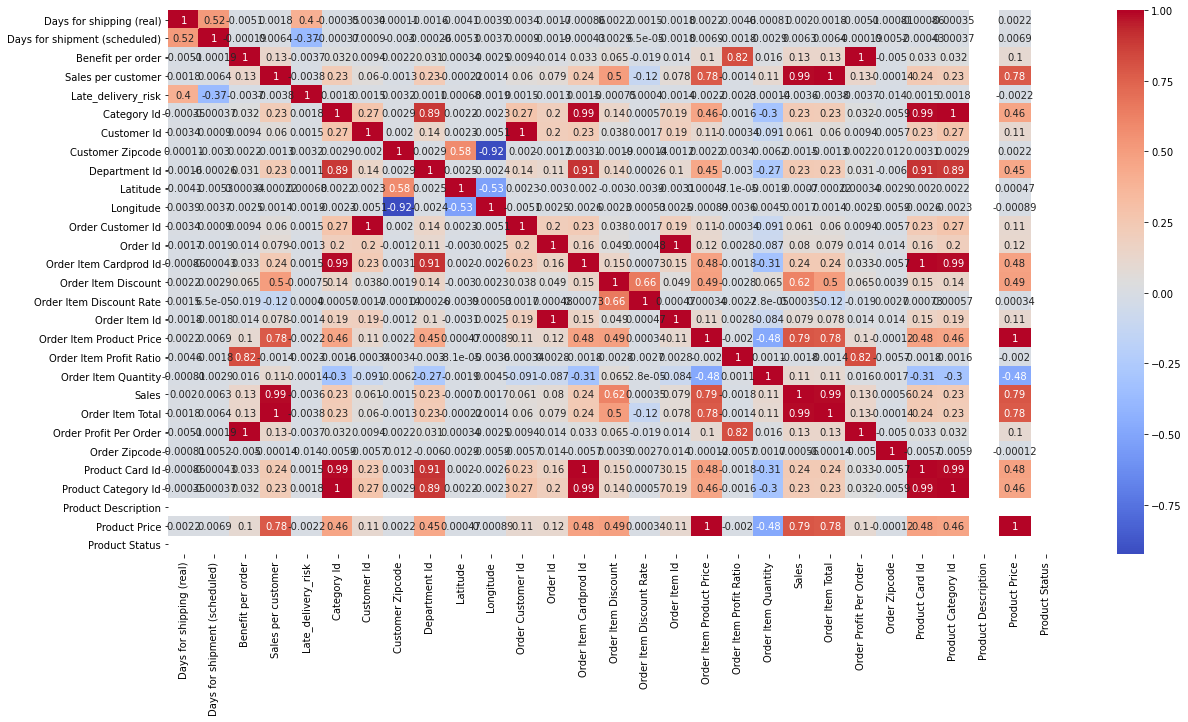

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
# 热力图展示特征相关性
plt.figure(figsize=(20,10))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')

**完全相关的属性**

Order Profit Per Order - Benefit per order

Product Category Id - Category Id

Order Item Total - Sales per customer

Order Item Id - Order Id

Order Customer Id - Customer Id

Product Card Id - Order Item Cardprod Id

Product Price - Order Item Product Price

Text(0.5, 1.0, 'Sales in different Departments')

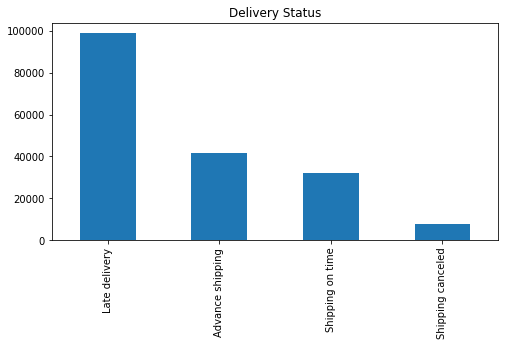

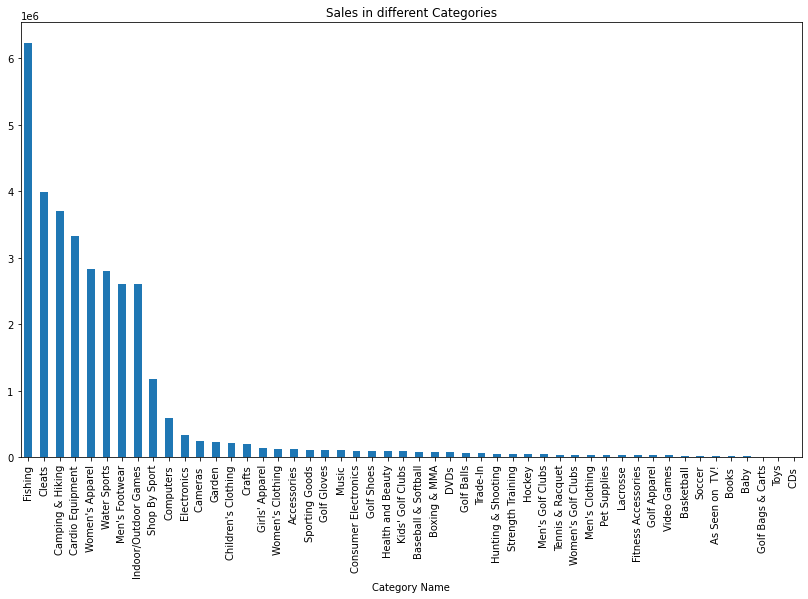

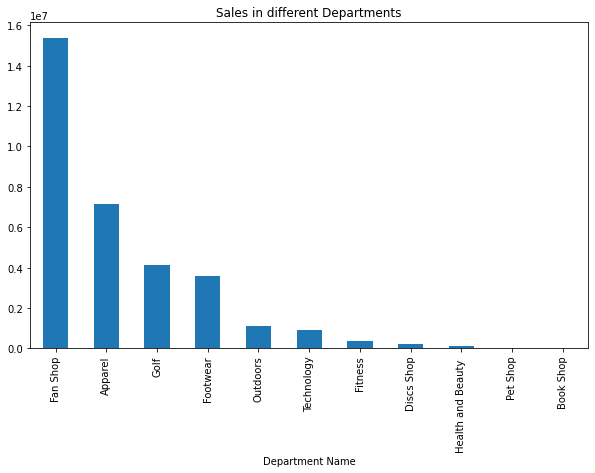

In [29]:
# 按不同的属性进行数据融合
plt.figure(1, figsize=(8,4))
ds = dataset['Delivery Status'].value_counts().plot.bar()
plt.title('Delivery Status')

plt.figure(2, figsize=(14,8))
cn = dataset.groupby('Category Name')
cn['Sales per customer'].sum().sort_values(ascending=False).plot.bar()
plt.title('Sales in different Categories')

plt.figure(3, figsize=(10,6))
dn = dataset.groupby('Department Name')
dn['Sales per customer'].sum().sort_values(ascending=False).plot.bar()
plt.title('Sales in different Departments')

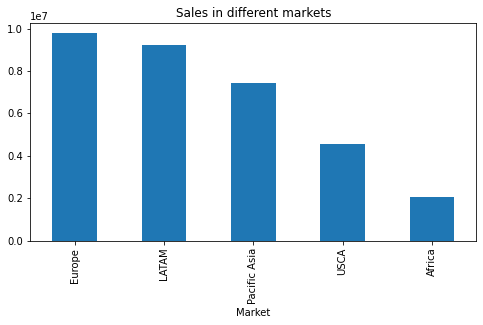

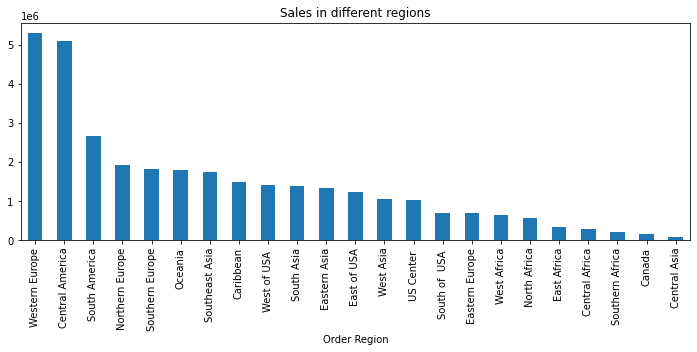

In [30]:
# 按照不同的Market, Order Region进行数据聚合
market = dataset.groupby('Market')
market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(8,4), title='Sales in different markets')
plt.show()
regions = dataset.groupby('Order Region')
regions['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,4), title='Sales in different regions')
plt.show()

###时间维度探索

In [31]:
# 按照不同的时间维度（年，月，星期，小时）的趋势
temp = pd.DatetimeIndex(dataset['order date (DateOrders)'])

In [32]:
# 取datetime中的year, month, weekday, hour, month_year
dataset['order_year'] = temp.year
dataset['order_month'] = temp.month
dataset['order_weekday'] = temp.weekday
dataset['order_hour'] = temp.hour
dataset['order_month_year'] = temp.to_period('M')
#dataset[['order_year', 'order_month', 'order_weekday', 'order_hour', 'order_month_year']]
dataset.drop(['order date (DateOrders)'],axis=1,inplace=True)

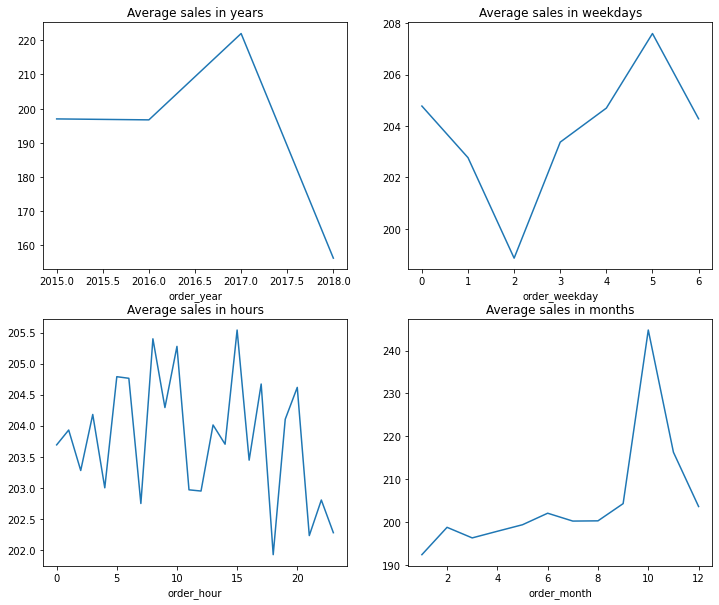

In [33]:
# 对销售额进行探索，按照不同的时间维度
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
df_year = dataset.groupby('order_year')
df_year['Sales'].mean().plot(figsize=(12,10), title='Average sales in years')

plt.subplot(2,2,2)
df_day = dataset.groupby('order_weekday')
df_day['Sales'].mean().plot(figsize=(12,10), title='Average sales in weekdays')

plt.subplot(2,2,3)
df_hour = dataset.groupby('order_hour')
df_hour['Sales'].mean().plot(figsize=(12,10), title='Average sales in hours')

plt.subplot(2,2,4)
df_month = dataset.groupby('order_month')
df_month['Sales'].mean().plot(figsize=(12,10), title='Average sales in months')

plt.show()

##RFM用户分层

In [34]:
# Recency value
# 最后一笔订单时间
temp.max()

Timestamp('2018-01-31 23:38:00')

In [35]:
# assume present time is 2018-2-1
import datetime
present = datetime.datetime(2018, 2, 1)
# compute RFM value for each user
dataset['order date'] = temp
dataset['Total Price'] = dataset['Order Item Quantity'] * dataset['Order Item Total'] # M value
#################################
#Recency: order date     ##
#Frequency: Oder Id      #
#Monetary: Total Price    ##
#################################
customer_rfm = dataset.groupby('Order Customer Id').agg({'order date': lambda x: (present-x.max()).days,\
          'Order Id': lambda x: len(x), 'Total Price': lambda x: x.sum()})
customer_rfm.set_axis(['R','F','M'], axis=1, inplace=True)
customer_rfm

,R,F,M
Order Customer Id,,,
1,792,1,2362.250061
2,136,10,2842.700073
3,229,18,6143.760057
4,380,14,4370.629991
5,457,7,2993.790032
...,...,...,...
20753,0,1,161.869995
20754,0,1,172.660004
20755,0,1,314.640015


In [37]:
# split RFM value into 4 level
# find the quantiles of R,F,M
quantiles = customer_rfm.quantile([0.25, 0.5, 0.75])
quantiles

,R,F,M
0.25,75.0,1.0,258.040008
0.50,159.0,7.0,2573.794999
0.75,307.0,15.0,6003.142554


In [39]:
# transfer RFM_value to R,F,M score
def R_score(a,b,c):
  if a <= c[b][0.25]:
    return 4
  elif a <= c[b][0.5]:
    return 3
  elif a <= c[b][0.75]:
    return 2
  else:
    return 1

def FM_score(a,b,c):
  if a <= c[b][0.25]:
    return 1
  elif a <= c[b][0.5]:
    return 2
  elif a <= c[b][0.75]:
    return 3
  else:
    return 4

# create another fields store the RFM score
customer_rfm['R_score'] = customer_rfm['R'].apply(R_score, args=('R', quantiles))
customer_rfm['F_score'] = customer_rfm['F'].apply(FM_score, args=('F', quantiles))
customer_rfm['M_score'] = customer_rfm['M'].apply(FM_score, args=('M', quantiles))
customer_rfm

,R,F,M,R_score,F_score,M_score
Order Customer Id,,,,,,
1,792,1,2362.250061,1,1,2
2,136,10,2842.700073,3,3,3
3,229,18,6143.760057,2,4,4
4,380,14,4370.629991,1,3,3
5,457,7,2993.790032,1,2,3
...,...,...,...,...,...,...
20753,0,1,161.869995,4,1,1
20754,0,1,172.660004,4,1,1
20755,0,1,314.640015,4,1,2


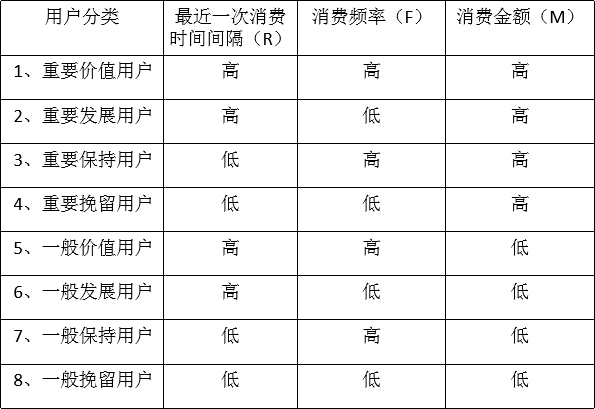

In [40]:
# 进行用户分层
def RFM_user(df):
  if df['M_score'] > 2 and df['F_score'] > 2 and df['R_score'] > 2:
    return '重要价值用户'
  if df['M_score'] > 2 and df['F_score'] <= 2 and df['R_score'] > 2:
    return '重要发展用户'
  if df['M_score'] > 2 and df['F_score'] > 2 and df['R_score'] <= 2:
    return '重要保持用户'
  if df['M_score'] > 2 and df['F_score'] <= 2 and df['R_score'] <= 2:
    return '重要挽留用户'
  if df['M_score'] <= 2 and df['F_score'] > 2 and df['R_score'] > 2:
    return '一般价值用户'
  if df['M_score'] <= 2 and df['F_score'] <= 2 and df['R_score'] > 2:
    return '一般发展用户'
  if df['M_score'] <= 2 and df['F_score'] > 2 and df['R_score'] <= 2:
    return '一般保持用户'
  if df['M_score'] <= 2 and df['F_score'] <= 2 and df['R_score'] <= 2:
    return '一般挽留用户'

customer_rfm['Customer_level'] = customer_rfm.apply(RFM_user, axis=1)
customer_rfm

,R,F,M,R_score,F_score,M_score,Customer_level
Order Customer Id,,,,,,,
1,792,1,2362.250061,1,1,2,一般挽留用户
2,136,10,2842.700073,3,3,3,重要价值用户
3,229,18,6143.760057,2,4,4,重要保持用户
4,380,14,4370.629991,1,3,3,重要保持用户
5,457,7,2993.790032,1,2,3,重要挽留用户
...,...,...,...,...,...,...,...
20753,0,1,161.869995,4,1,1,一般发展用户
20754,0,1,172.660004,4,1,1,一般发展用户
20755,0,1,314.640015,4,1,2,一般发展用户
